# Fast PDE/IE course, Skoltech, Spring 2015

# Problem (80 pts).  Integral Equations of Computational Electromagnetics on uniform grids

## 1. Original differential equation

Wave phenomena play very important role in many aspects of physics of our world. They arise in acoustics, radio and optical telecommunications and take major role in many devices, from car acoustics to MRI and nanooptical systems on chip. Engineers from many fields need to be able to model them properly. 

Full equations for those phenomena differ (Maxwell's equations, continious media equations and Shroedinger's equations), under some simplifying assumptions. However, in case of time-harmonic solution and right-hand side ($u({\bf r},t) \sim \rho ({\bf r},t) \sim exp(i \omega t)$), they all become equivalent to scalar or vector Helmholtz equation (in Electromagnetic community it is also called Vector Wave equation):

$$\nabla ^2 u({\bf r}) + k_0^2 \epsilon_r({\bf r}) u({\bf r}) = \rho({\bf r}), $$

$$\nabla \times \nabla \times \vec{E}({\bf r}) + \epsilon_r({\bf r}) \mu_r({\bf r}) k_0^2 \vec{E}({\bf r}) = \vec J({\bf r}) ,$$
$$k_0 = \frac{2 \pi}{\lambda_0}=\frac{\omega}{c},$$

where $\lambda_0$ is wavelength in free space (usually one considers air or vacuum as free space), $\omega = 2\pi \nu$ is the angular frequency in radians per second, $c$ is speed of the wave in the free space (sound or light depending on the problem),
$\epsilon_r$ - relative dielectric permittivity, $\mu_r$ - relative magnetic permeability, $E({\bf r})$ electric ﬁeld strength, $J({\bf r})$ dipole current density and  ${\bf r} = (x,y,z)$ is the vector deﬁning the location of the observation point. Everything is taken in Gaussian units.

In case of (infinite) translational symmetry along one of the axis (Z) those equations become two-dimensional.
For the vector Helmhotz equation one also needs to consider additional assumptions so that the equation becomes scalar:
 - Dipole current $\vec J({\bf r})$ has only $J_z({\bf r})$ component
 - materials are isotropic and nonmagnetic
 
After all this simplifications made only $E_z({\bf r})$ component of the solution can be non-zero and one obtains the final scalar system of equations in 2D:

$$
\nabla ^2 E_z({\bf r}) + k_0^2 \epsilon_r({\bf r}) E_z({\bf r}) = J_z({\bf r}), 
$$
$${\bf r}\in  \Omega,\space \Omega=[-1,1] \times [-1,1]$$

Sommerfeld (or Radiation) boundary conditions
$$\lim_{|{\bf r}| \to \infty} |{\bf r}| \left( \frac{\partial E_z({\bf r})}{\partial |{\bf r}|} - i k_0 |{\bf r}| \right) = 0.$$ 
emulate placing our objects in the free space (or perfect noise chamber). In the physical sense, they mean that far fields look like escaping plane waves with the same frequency, and amplitudes are decaying according to the energy conservation law.

When Sommerfeld boundary conditions are used, it is often called a scattering problem, or open-space scattering problem.

One should note that $\epsilon_r({\bf r})=1$ corresponds to empty space.
Due to relatively general setup of the equation, one can re-discover many interesting well-known effects even with this simplified 2D solver.

### Example solutions

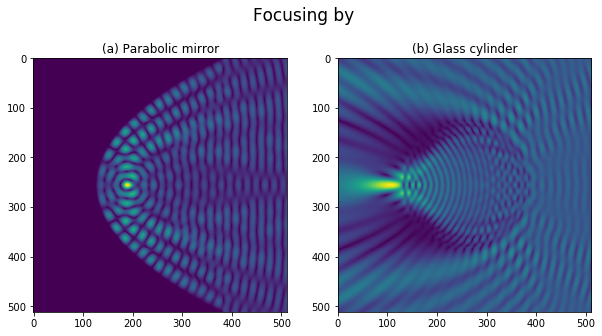

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 512
data_parab = h5py.File('PS1.mat')['x_fft'][()]
data_cyl = h5py.File('PS1_cyl.mat')['x_fft'][()]
rp = data_parab['real'].reshape(n, n, order='f')
ip = data_parab['imag'].reshape(n, n, order='f')
rc = data_cyl['real'].reshape(n, n, order='f')
ic = data_cyl['imag'].reshape(n, n, order='f')
p = np.sqrt(rp ** 2 + ip ** 2).T
c = np.sqrt(rc ** 2 + ic ** 2).T

fig = plt.figure(figsize=(10, 10))
plt.suptitle('Focusing by', y=0.75, fontsize=17)
plt.subplot(1, 2, 1)
plt.imshow(p)
plt.title('(a) Parabolic mirror')
plt.subplot(1, 2, 2)
plt.imshow(c)
plt.title('(b) Glass cylinder')

## 2. An Integral Equation formulation (15pts)
* (7 pts) Show that the 2D Helmholtz equation with Radiation boundary conditions can be represented in the (Lippmann-Schwinger) integral equation form
$$
E_z({\bf r}) +  k_0^2 \int \left( \epsilon_r({\bf r})-1 \right) E_z({\bf r'}) G\left(\left|{\bf r}-{\bf r'}\right|\right) d{\bf r'} = 
f({\bf r}),\\
f({\bf r})=\int J_z({\bf r'})G\left(\left|{\bf r}-{\bf r'}\right|\right) d{\bf r'} 
$$
where 
$$
G(x) = \frac{i}{4} H^{(2)}_0(x)
$$
is the Green’s function to the 2D Helmholtz operator - Hankel function of zeroth order of second kind. (Note that depending on the complex sign notation, $H^{(2)}_0(x)$ may be replaced with $H^{(1)}_0(x)$). What kind of integral equation is this?
* (3 pts) Strictly speaking, the right hand side $ f({\bf r}) $ of the integral equation may be taken from a wider class than just $f({\bf r})=\int J_z({\bf r'})G({\bf r}-{\bf r'}) d{\bf r'}$. If we need to simulate incoming plane wave 
$f({\bf r})=\text{exp}(i k_{0}^{(x)} x + i k_{0}^{(y)} y)$, what kind of source current distribution $J_z({\bf r'})$ one needs? What is the problem to have this distribution in our simulations?

* (5 pts) Explain why the integral formulation is more preferrable for the open-space scattering problem  as compared to the differential formulation

## 3. Discretization

There are several methods to discretize our continious equation, most of which have second order of convergence with the step of discretization, but with different constants.
Due to the fact that here we are dealing with 2D problem, we can afford to use reasonably fine grids, so even simple methods of discretization produce realistic results.

Let us consider uniform $N \times N$ pixel grid  on our square domain $\Omega=\bigcup_{i=1}^{N^2} \Omega_i.$

Let us force our original continious equation to hold at central points of the right edges $ {\bf r^{edge}_i}$ ("receivers") of each pixel. Then our system becomes:

$$Ax=b$$
$$A=I + k_0^2 \space G\space  \text{diag}(\epsilon - 1)$$
$$G_{ij}= \int_{\Omega_j} G \left( k_0\left|  {\bf {\bf r^{edge}_i}}-{\bf r'} \right| \right) d{\bf r'} =$$
$$=\frac{i}{4}\int_{x^{}_j-h/2}^{x^{}_j+h/2} \int_{y^{}_j-h/2}^{y^{}_j+h/2} 
H_0^{(2)}\left(k_0 \sqrt{ (x^{edge}_i - x)^2+(y^{edge}_i - y)^2  } \right) dydx \simeq \frac{ih^2}{4} H_0^{(2)} \left( k_0\left|  {\bf r^{edge}_i}-{\bf r^{center}_j} \right| \right)$$

$k_0=\frac{2\pi}{\lambda}$, lambda is given in the domain units.

This is a Nystrom-type  discretization on shifted grids.
With this formulation one avoids dealing with singular integrals.

### Material distribution $\epsilon(x)$

Material distribution must be given by a function $\epsilon(x)$ on our pixel grid. 

For devices made of solid homogenious material with $\epsilon_r=\epsilon_{device}$, the material distribution may be introduced using a binary mask of this device. $\text{mask}({\bf r})=1$ in points where the  device is present and $\text{mask}({\bf r})=0$ elsewhere. So that
$\epsilon_r({\bf r})=1+(\epsilon_{device} - 1) \text {mask}({\bf r})$, where $\text{mask}({\bf r})$ is a binary function.
#### Soft masks
Due to the using of pixel grid, for any device with distinct boundary (such as glass lens, for example) one will probably get ladder pixelization artefacts on the boundary of device, which will introduce fake sharp edges and create unwanted point-like reflections. To raise the precision in that case, one should use anisotropically smoothened material functions instead of hard (inequality-based) conditions. 

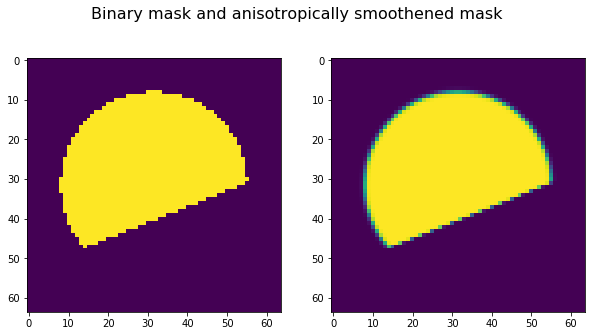

In [5]:
# Comparison of hard and soft mask
N = 64
xmin = -1
xmax = 1
ymin = xmin
ymax = xmax

XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), 
                     np.linspace(ymin, ymax, N))

shape1 = XX + 2.5*YY - 0.7
shape2 = np.sqrt(XX**2 + YY**2) - 0.75

def smooth(f, alpha):
    return 0.5*(1 + np.tanh(-alpha*f))

# using hard (inequality) conditions
mask1 = (shape1<0).astype(float) * (shape2<0).astype(float)

# anisotropically smoothened conditions
alpha = 1*N; # for a smoothened layer to be approximately equal to 2 pixels, one should take alpha~N
mask2 = smooth(shape1, alpha) * smooth(shape2, alpha)

fig = plt.figure(figsize=(10, 10))
plt.suptitle('Binary mask and anisotropically smoothened mask', y=0.75, fontsize=16)
plt.subplot(1, 2, 1)
plt.imshow(mask1)
plt.subplot(1, 2, 2)
plt.imshow(mask2)

### 4. A Fast Integral Equation Solver (25pts)
Invertion of the matrix directly with Gaussian elimination would cost $\mathcal{O}(N^3)$. 

Fortunately, the G matrix part of our matrix $A$ has a block-Toeplitz structure that can be exploited to
solve the linear system using an iterative method with $\mathcal{O}(N \log N)$ complexity per matvec by embedding $A$ into a block-circulant matrix with circulant blocks.

* (5 pts) Prove that after Nystrom discretization the operator will take a form: $$A=I + k_0^2 \space G\space  \text{diag}(\epsilon - 1),$$ where $\epsilon$ is an array of relative dielectric permittivity reshaped into a vector, $\text{diag}$ creates diagonal matrix from the vector, difference in understood element-wise.
* (10 pts) Show that $G$  has block-Toeplitz with Toeplitz blocks structure. Describe the steps required to implement the matvec by $A$ using the FFT.
* (10 pts) Implement a fast matrix-vector (matvec) product function that will quickly evaluate the product $Ax$ for
a given $x$ and $\chi(x)$.



### 5. Basic tests (10 pts)
* (5 pts) Show that in case of no scatterer solution is exactly equal to the right-hand side. Print the relative error:
$$err=\frac{|E_z-f|}{|f|}$$
* (5 pts) **Law of reflection**.
Consider a scattering problem. Source field then is an incoming plane wave: 
$$f({\bf r})=\text{exp}(i k_{0}^{(x)} x + i k_{0}^{(y)} y),$$
where $k_{0}^{(x)}= k_0 \cos\theta$, $k_{0}^{(y)}= k_0 \sin\theta$.
Scatterer is a wall of perfect electric conductor ($x\leq -0.75 \Rightarrow \epsilon=-50$, $x>-0.75 \Rightarrow \epsilon=1$) with incidence angle $\theta=\frac{\pi}{4}$.
Plot the real part the solution, make sure the field distribution has a square 'checkboard' structure. Explain why it is.


### 6. Experiments with devices (30 pts) 


Now when you have the fast solver, it is interesting to obtain some well-known phenomena from optics.
To simulate a device is to define a nontrivial distribution of complex dielectric permittivity $\epsilon (x)$.
For example, $\epsilon = n^2= 2.25$ roughy corresponds to glass, $\epsilon = -100$ to Perfect Electric Conductor, $\epsilon = 16 + 20j$ may correspond to some metal, depending on the frequency.

Embed the matvec function from the bullet above into ```GMRES```, feed proper material distribution for your device and solve the integral equation for either of the following cases without explicitly forming the dense coupling matrix. Produce iteration-residual plots at both frequencies, and the scattered image. 

* (12 pts) Problem 1. Parabolic reflector. Consider a parabolic mirror plate region given by inequality $Y-X^2+0.75\leq0$ filled with Perfect Electric Conductor $\epsilon = -50$.  (Note: remember, that is pixel world you should use smoothening).
Consider a source field of a point dipole $$f({\bf r})=   H_0^{(2)} \left( k_0\left|  {\bf r}-{\bf r^{dipole}} \right| \right)$$.
Show based on simulations that there exists a point, where one can place the dipole such that the parabolic mirror transforms its radiation pattern into the plane wave.


* (18 pts) Problem 2. Consider a symmetric dielectric lens with circular boundaries and $\epsilon=4$. Long dimension of the lens equals $2$. Both curvature radii of lens surfaces $R_1=R_2=3$. Lens is placed such that it sticks to one of the edges of computational domain. Consider a plane wave source field $f({\bf r})=\text{exp}(i k_{0} x)$. The point with the highest field modulus is called focus point. 
Run the series of simulations for wave vectors $k_0^{(m)}=2\pi m$, where $m = {2,...,5}$. Plot the complex modulus of the field distributions. Plot the field profiles in the focal plane. Show that width of the focus light spot is linearly dependent on $\lambda=\frac{k_0}{2\pi}$

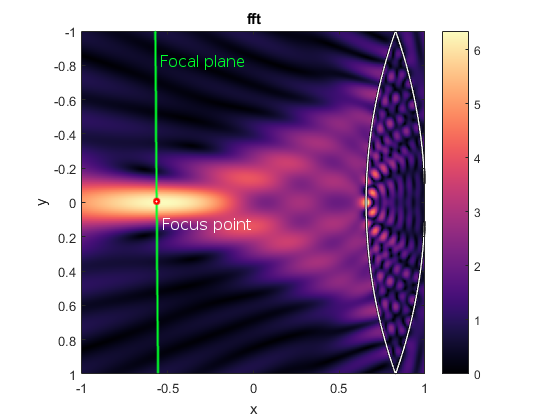

In [6]:
from IPython.display import Image
Image("uberlens.png")